<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/kalman/signal_kalman_banknifty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pykalman
!pip install yfinance
!pip install pandas-ta==0.2.45b

     |████████████████████████████████| 228 kB 27.7 MB/s 
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48462 sha256=54cb3e2eced2380a322b433e975e8ca4d40048de909461c41ab12c3639e158cf
  Stored in directory: /root/.cache/pip/wheels/6a/04/02/2dda6ea59c66d9e685affc8af3a31ad3a5d87b7311689efce6
Successfully built pykalman
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 6.4 MB 33.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you hav

In [2]:
#Importing dependencies#
from pykalman import KalmanFilter
import numpy as np
import pylab as pl
import pandas as pd
import yfinance as yf
from scipy import poly1d
from datetime import datetime
import pandas_ta as ta
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
ticker = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_niftybanklist.csv')

In [5]:
#ticker = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_nifty50list.csv')
START = "2013-01-01"

In [6]:
nifty=yf.download('^nsebank',start=START)

[*********************100%***********************]  1 of 1 completed


In [7]:
lst=[]
for i in range(len(ticker)):
  
  dfi = yf.download(str(ticker.Symbol.iloc[i])+'.ns', start=START)
  df = dfi[['Adj Close']]
  f = KalmanFilter(transition_matrices = [1],
                    observation_matrices = [1],
                    initial_state_mean = 0,
                    initial_state_covariance = 1,
                    observation_covariance = 1,
                    transition_covariance = 0.0001)
  mean, cov = f.filter(df['Adj Close'].values)
  mean, std = mean.squeeze(), np.std(cov.squeeze())
  var = 'kalman'
  df[var]=df['Adj Close'].values - mean
  
  lst.append(df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
nlst=[]
for i in range(len(ticker)):
  nlst.append(lst[i].kalman)
  

In [9]:
df_kalman = pd.DataFrame(nlst).T

In [10]:
namelist =[]
for i in range(1,len(ticker)+1):
  namelist.append('kalman_'+str(i))
  
df_kalman.columns = namelist

In [11]:
def macd_calc(df):
  columns=df.columns.tolist()
  for var in columns:
    macd='macd'+var
    macd_s='macd'+'signal'+var
    macd_h='hist'+ var
    df[macd]=df[var].ewm(span=26, adjust=False).mean()-df[var].ewm(span=50, adjust=False).mean()
    df[macd_s]=df[macd].ewm(span=18,adjust=False).mean()
    df[macd_h]=df[macd]-df[macd_s]
  return df

In [12]:
final_kalman=macd_calc(df_kalman)

In [13]:
final_kalman.tail(2)

,kalman_1,kalman_2,kalman_3,kalman_4,kalman_5,kalman_6,kalman_7,kalman_8,kalman_9,kalman_10,kalman_11,kalman_12,macdkalman_1,macdsignalkalman_1,histkalman_1,macdkalman_2,macdsignalkalman_2,histkalman_2,macdkalman_3,macdsignalkalman_3,histkalman_3,macdkalman_4,macdsignalkalman_4,histkalman_4,macdkalman_5,macdsignalkalman_5,histkalman_5,macdkalman_6,macdsignalkalman_6,histkalman_6,macdkalman_7,macdsignalkalman_7,histkalman_7,macdkalman_8,macdsignalkalman_8,histkalman_8,macdkalman_9,macdsignalkalman_9,histkalman_9,macdkalman_10,macdsignalkalman_10,histkalman_10,macdkalman_11,macdsignalkalman_11,histkalman_11,macdkalman_12,macdsignalkalman_12,histkalman_12
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-02-03,241.336654,77.799941,23.367106,14.020017,14.493193,104.205679,-0.250434,-12.894993,46.989647,3.209052,-31.407985,94.850071,30.441039,9.017278,21.423761,10.765771,0.017025,10.748746,9.547876,3.452016,6.095860,1.383207,0.310679,1.072527,-10.686783,-13.404668,2.717884,3.351158,1.678392,1.672767,-0.254494,-0.193601,-0.060894,-15.032049,-27.026715,11.994666,-15.120008,-24.229748,9.109740,0.278956,-0.136215,0.415170,-5.204959,-7.124491,1.919532,3.557866,-1.479164,5.037030
2022-02-04,202.353030,76.035772,18.332852,11.801413,22.912939,99.307601,-0.742967,-15.043788,21.919258,2.088068,-34.956675,84.203825,31.875901,11.423449,20.452452,12.205624,1.300035,10.905589,9.907653,4.131556,5.776097,1.386043,0.423876,0.962168,-9.759531,-13.020969,3.261439,3.173587,1.835781,1.337806,-0.238634,-0.198341,-0.040293,-12.535367,-25.501310,12.965943,-14.886705,-23.246270,8.359565,0.312614,-0.088969,0.401584,-4.901481,-6.890490,1.989009,3.789330,-0.924586,4.713916


In [14]:
features = final_kalman.columns.tolist()

In [15]:
feats_set1=[feats for feats in features if feats.startswith('hist')]

In [16]:
final_dataframe=final_kalman[feats_set1]

In [17]:
solution=np.sign(final_dataframe)

In [18]:
solution['final']=solution.sum(axis=1)

In [19]:
solution.tail(2)

,histkalman_1,histkalman_2,histkalman_3,histkalman_4,histkalman_5,histkalman_6,histkalman_7,histkalman_8,histkalman_9,histkalman_10,histkalman_11,histkalman_12,final
Date,,,,,,,,,,,,,
2022-02-03,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,10.0
2022-02-04,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,10.0


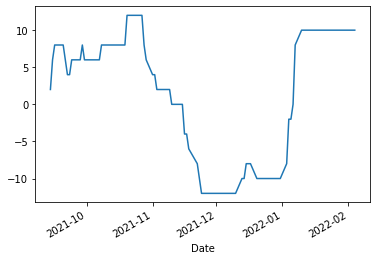

In [20]:
solution.final[-100:].plot()

In [22]:
solution['mov_avg']=solution['final'].rolling(window=10).mean()

In [23]:
l=300

In [24]:
nifty=nifty[-l:]
solution=solution[-l:]

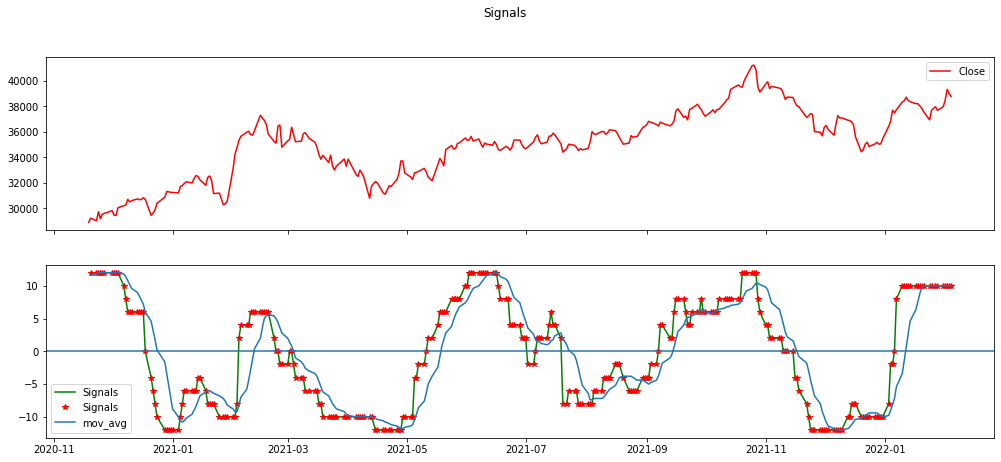

In [25]:
fig, ax = plt.subplots(2,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'Close'],'r', label='Close')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'final'],'g', label='Signals')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'final'],'r*', label='Signals')
ax[1].plot(solution.iloc[:, :].index, solution.loc[:, 'mov_avg'], label='mov_avg')
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend()
ax[1].axhline(y=0)
plt.show()

In [26]:
solution['signals']=np.where(solution['final']>0,1,-1)

In [27]:
solution.final.tail(1)

Date
2022-02-04    10.0
Name: final, dtype: float64

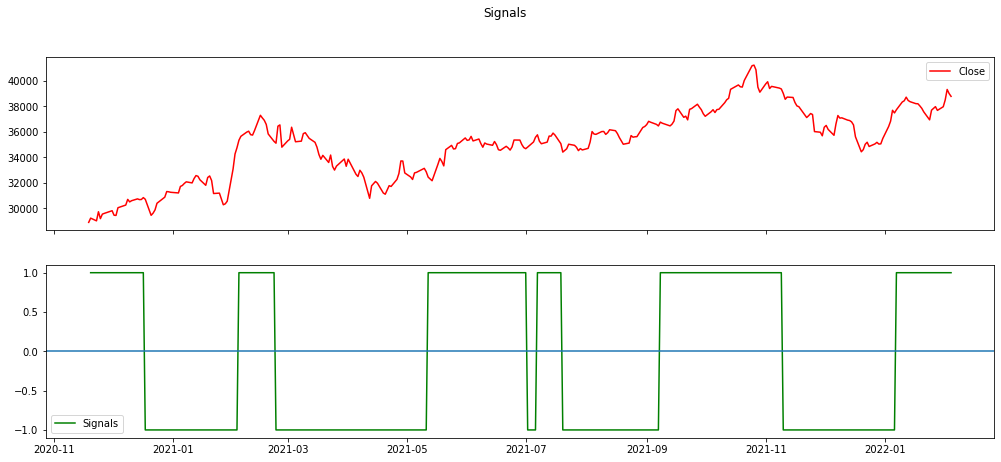

In [28]:
fig, ax = plt.subplots(2,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'Close'],'r', label='Close')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'signals'],'g', label='Signals')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend()
ax[1].axhline(y=0)
plt.show()

In [29]:
solution[['signals']].to_csv('kalman_k.csv')

In [30]:
solution['local_max'] = solution['final'][
  (solution['final'].shift(1) < solution['final']) &
  (solution['final'].shift(-1) < solution['final'])]
solution['local_min'] = solution['final'][
  (solution['final'].shift(1) > solution['final']) &
  (solution['final'].shift(-1) > solution['final'])]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(15, 8))
plt.plot(solution['final'], zorder=0)
plt.scatter(solution.index, solution['final'], s=100,
  label='Maxima', marker='^', c=colors[1])
plt.scatter(solution.index, solution['local_min'], s=100,
  label='Minima', marker='v', c=colors[2])
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Local Maxima and Minima ')
plt.legend()
plt.show()

ConversionError: ignored

<Figure size 1080x576 with 1 Axes>

In [31]:
from scipy.signal import argrelextrema

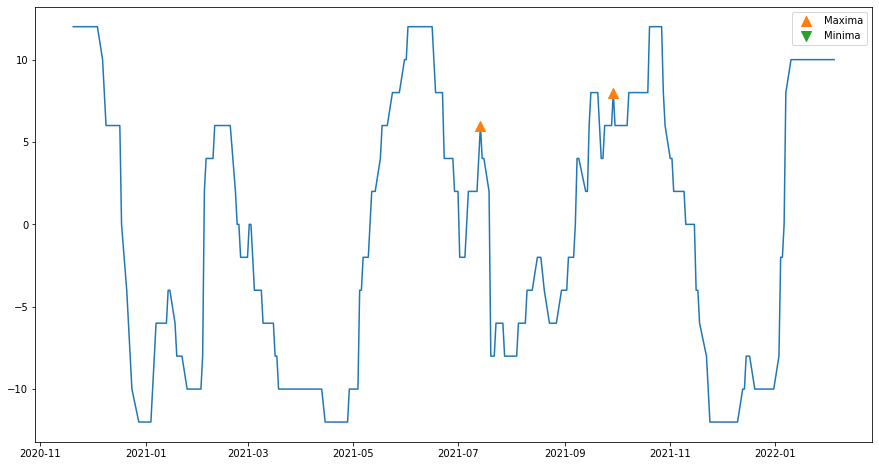

In [32]:
max_idx = argrelextrema(solution['final'].values, 
  np.greater, order=3)[0]
min_idx = argrelextrema(solution['final'].values, 
  np.less, order=3)[0]
plt.figure(figsize=(15, 8))
plt.plot(solution['final'], zorder=0)
plt.scatter(solution.iloc[max_idx].index, solution.iloc[max_idx]['final'],
  label='Maxima', s=100, color=colors[1], marker='^')
plt.scatter(solution.iloc[min_idx].index, solution.iloc[min_idx]['final'],
  label='Minima', s=100, color=colors[2], marker='v')
plt.legend()
plt.show()